In [1]:
from scipy.optimize import curve_fit
import numpy as np 
import matplotlib.pyplot as plt
import h5py
from numpy import ma
import os


def gauss_1(x, amp1, cen1, sigma1):
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2)))

def gauss_3(x, amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3):
    """ Fitting Function"""
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2))) + \
           amp2 * (np.exp((-1.0 / 2.0) * (((x - cen2) / sigma2) ** 2))) + \
           amp3 * (np.exp((-1.0 / 2.0) * (((x - cen3) / sigma3) ** 2)))

def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2   


def log_decay_radim_s2(x, T, amp, offset, dB, alpha0):
    # xi = calc_squeez_parameter(dB)
    # s = np.exp(-xi)
    return offset-np.log(amp*np.exp(-x*s(dB)**2/(2*T)*alpha0**2))

def s(dB):
    return np.sqrt(10**(-dB/10))

In [4]:
## setup the fitting model

from lmfit import Model


gmodel = Model(log_decay_radim_s2)
print(f'parameter names: {gmodel.param_names}')
print(f'independent variables: {gmodel.independent_vars}')

gmodel.set_param_hint('T', value=200)
gmodel.set_param_hint('amp', value=1, vary = False)
gmodel.set_param_hint('offset', value=0, vary = False)
gmodel.set_param_hint('dB', value=0, vary = False)
gmodel.set_param_hint("alpha0", value = 3.47, vary = False)
params = gmodel.make_params()


parameter names: ['T', 'amp', 'offset', 'dB', 'alpha0']
independent variables: ['x']


### Load data without averages

In [5]:
def load_data_no_average(path: str, file_end: str, thresh, vac_norm = 1, plot = True): 
    """_summary_

    Args:
        path (str): folder where files are located
        file_end (str): ending of files to load
        
    Returns:
        dd (dict): keys are time stamps and value is a non averaged data set of size (number of total reps, x, y)
    """
    fps = []
    fp = [path + f for f in os.listdir(path) if f.endswith(file_end +'.h5')]
    fps = np.concatenate([fp[:]])
    
    dg = []
    de = []
    dts = []
    for kk in range(len(fps)):
        fname = fps[kk]
        df = h5py.File(fname, "r")
        data = df["data"]
        data_i = data["I"][:]
        data_q = data['Q'][:]
        dt = df.attrs['decay_time']
        x = data["x"][:, 0]
    #y = data["y"][0, :, 0]
    
#         ss_data = np.where(data_i < thresh, 1, 0)
#         thresh_1 = 6.30337300715842e-05
        raw_m0 = data_i[:, 0::3]
        raw_m1 = data_i[:, 1::3] 
        raw_m2 = data_i[:, 2::3]
        
        m0 = np.where(raw_m0 < thresh, 1, 0)
        m1 = np.where(raw_m1 < thresh, 1, 0)
        m2 = np.where(raw_m2 < thresh, 1, 0)
        
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)
        ## I only care about the double selected data!
        ## I use filled to replace all masked arrays with nan. This allows me to not care about masks after this point. This is useful, as i can later use np.nanmean to calculate the mean value.
        double_ps_g = ma.masked_array(m2_g, mask=m1_g, dtype='float').filled(np.nan).reshape(df.attrs["reps"],len(x))*2 - 1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g), dtype='float').filled(np.nan).reshape(df.attrs["reps"], len(x))* 2 - 1
        dg.append(double_ps_g/vac_norm)
        de.append(double_ps_e/vac_norm)
        dts.append(dt)

    dg = np.array(dg)
    de = np.array(de)
    dts = np.array(dts)
    decay_times = np.unique(dts)

    
    dd = {}
    # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            dd[str(decay_times[n])] = []

    # use dts to sort the values by decay time into the correct bin
    for n, dt in enumerate(dts):
        dd[str(dt)].append(dg[n])
      
    # stack all arrays that were in the list
    for dt in decay_times:
        dd[str(dt)] = np.vstack(np.array(dd[str(dt)]))
    
    rows = 1
    cols = len(decay_times)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
    for i in range(rows):
        for j in range(cols):
            
            axes[j].plot(x,  np.nanmean(dd[str(decay_times[j])][:, :], axis = 0))
            axes[j].set_aspect("equal")
            axes[j].set_title(str(decay_times[j]))     
        plt.show()
    return dd, decay_times, x
    
def bootstrap_resample_1D(X):
    n = np.shape(X)[0]
    X_resample = np.zeros_like(X.T)
    XT = X.T.copy()

    resample_i = np.floor(np.random.rand(n)*n).astype(int)
    for x in range(np.shape(X)[1]):         
                X_resample[:][x] = XT[x][resample_i]
    return X_resample.T
    
def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2


### Extract the time scales by fitting to radims logarithmic model

In [32]:
# include time_scale extraction

def extract_decay_constant_bootstrap(dd, decay_times, x, n_reps,initial_guess, bounds, dB, plot=False):
    
    ### Initialize two dictionaries that will be filled up and return in the end
    T_values = []
    


    # do the boostraping, n_rep times
    for rep in range(n_reps):
        ### 0. resample data and saved resampled data in new dictionary
        dd_bt = {}
        for j in range(len(decay_times)):
            dd_bt[str(decay_times[j])] = bootstrap_resample_1D(dd[str(decay_times[j])])
        
       
        popts_3gaussian = []
        averaged_data_list = []
        amps_one_run = []
        for i , time in enumerate(decay_times):  
            averaged_data =np.nanmean(dd_bt[str(time)], axis = 0)
            averaged_data_list.append(averaged_data) # used for plotting
            popt, pcov = curve_fit(gauss_3, x, averaged_data, p0=initial_guess, bounds=bounds,maxfev = 5000)
            popts_3gaussian.append(popt)
            amps_one_run.append((popt[0]+popt[6])/2) # used to extract time scale in next step
            
            if i == 0:
                # find alpha0 for the smallest t
                gamma0 = ((popt[1]-popt[7])/2) 
                z = calc_squeez_parameter(-dB)
                alpha0 = gamma0/(np.cosh(z)+np.sinh(z))
                print(gamma0, alpha0)
        
        # setup the fit

        # need to write this in a function to avoid namespace conflict with scipy curve_fit (both use params)
        def find_timescale(amps_one_run, decay_times, T_values, plot=plot):
            cut_step = 6
            params["dB"].value = dB
            params["alpha0"].value = 3.8
            y = -np.log(np.array(amps_one_run[: cut_step])/np.min(amps_one_run))
            x = decay_times[: cut_step]/1e3
            result = gmodel.fit(y, params, x=x)
            T_values.append(result.values["T"])
            
            
            # plt.plot(x, y, 'o')
            # plt.plot(x, result.init_fit, '--', label='initial fit')
            # plt.plot(x, result.best_fit, '-', label='best fit')
            # print(result.fit_report())
        find_timescale(amps_one_run, decay_times, T_values, plot)
  
       
    return T_values

## O dB

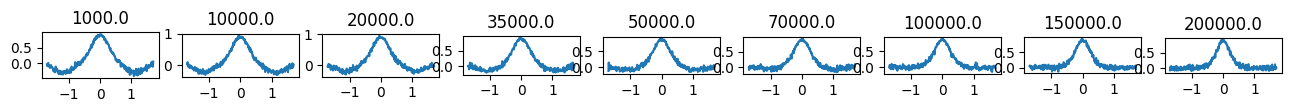

-3.4696519104508816 -3.4696519104508816
-3.452918232633561 -3.452918232633561
-3.481456332060194 -3.481456332060194
-3.491288811066233 -3.491288811066233
-3.4808955565603488 -3.4808955565603488
-3.497274458635925 -3.497274458635925
-3.473503145809257 -3.473503145809257
-3.4920814893655217 -3.4920814893655217
-3.490308788052589 -3.490308788052589
-3.480611543847135 -3.480611543847135
-3.491105370370886 -3.491105370370886
-3.4772585072761646 -3.4772585072761646
-3.466739578289987 -3.466739578289987
-3.449399523199114 -3.449399523199114
-3.446018480448727 -3.446018480448727
-3.4527939554167615 -3.4527939554167615
-3.4776095450687174 -3.4776095450687174
-3.483214812311277 -3.483214812311277
-3.4458719718207655 -3.4458719718207655
-3.4839521400317732 -3.4839521400317732
-3.499957829338471 -3.499957829338471
-3.4963328017112705 -3.4963328017112705
-3.46329020869334 -3.46329020869334
-3.4591566153620006 -3.4591566153620006
-3.4758916555031965 -3.4758916555031965
-3.4604871071381362 -3.4604871

In [7]:

thresh = 0.00021633181712747438
vac_norm = 1 #0.944
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
file_end = 'normal_cat_decay_loop_1d'
dd, decay_times, x = load_data_no_average(path, file_end, thresh = thresh, vac_norm=vac_norm)


# initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
scaling = 3
reps = 100

initial_guess = [-0.4, -3.6, 1, 1, 0, 1, -0.4, 3.6, 1]
bounds =([-1, -5, 0.4 ,0, -0.02, 0.2 ,-1,2.5, 0.4],
[0, 5, 1 ,1, 0.02, 1.1 ,0, 5, 1])

T_values_0 = extract_decay_constant_bootstrap(dd, decay_times, scaling*x, reps, plot=False, initial_guess=initial_guess, bounds=bounds, dB = 0)

In [8]:
print(f"{np.mean(T_values_0)}+-{np.std(T_values_0)}")


273.2201785569041+-13.024312605221818


## 3 dB


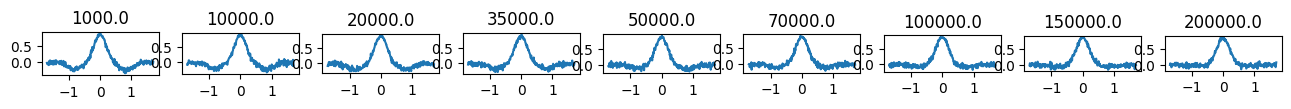

-2.466348080821084 -3.4838092622680574
-2.448727561960153 -3.458919617821259
-2.4319401556513975 -3.435206776133305
-2.447114213425145 -3.456640702442998
-2.468448519822414 -3.486776211217626
-2.4424939925457125 -3.4501144669863497
-2.4744472476879826 -3.4952496395477164
-2.4471492968287976 -3.4566902590678503
-2.376622957569352 -3.357069156979082
-2.474509234265277 -3.4953371979154073
-2.483557119900764 -3.508117676074986
-2.44523164954763 -3.4539815102858578
-2.4651456879993394 -3.482110837263958
-2.422393381056189 -3.421721598587522
-2.461942390633914 -3.4775860594687042
-2.469614038311407 -3.4884225498422805
-2.4347398456552938 -3.4391614433771136
-2.467907951636806 -3.4860126383600263
-2.4724673650688853 -3.4924529810142952
-2.44188134282462 -3.4492490762536043
-2.463285026161376 -3.479482582559988
-2.4322692828988335 -3.4356716807272667
-2.456087189841144 -3.469315368517611
-2.4183165816405214 -3.4159629663509956
-2.453303768816442 -3.4653836818177273
-2.4675145757140227 -3.48545

In [9]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
file_end = 'panther_sq_vcat_3db_oddcat_1d'
dd, decay_times, x = load_data_no_average(path, file_end, thresh=0.00016482562703811767, vac_norm=vac_norm)


# initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
scaling = 3
reps = 100

initial_guess = [-0.4, -3, 1, 1, 0, 1, -0.4, 2, 1]
bounds =([-1, -5, 0.2 ,0, -0.5, 0.2 ,-1,1.5, 0.2],
[0, -2, 1 ,1, 0.5, 1.1 ,0, 5, 1])

T_values_3 = extract_decay_constant_bootstrap(dd, decay_times, scaling*x, reps, plot=False, initial_guess=initial_guess, bounds=bounds, dB = 3)


In [10]:
print(f"{np.mean(T_values_3)}+-{np.std(T_values_3)}")

258.08568830077945+-16.57483833871806


## 6.7 dB

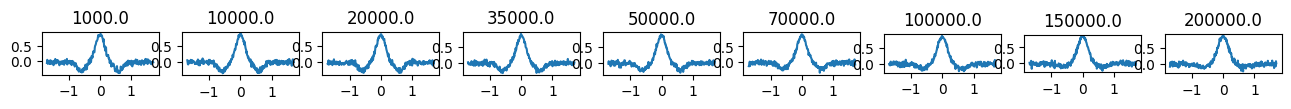

-1.7725115330164463 -3.833443525974446
-1.7732805043904813 -3.8351065946092877
-1.7517382838818967 -3.7885168352731595
-1.7623367455638395 -3.8114383246757084
-1.7873883051954453 -3.8656177967392344
-1.7698008180488907 -3.8275810125015695
-1.7471969203321729 -3.778695144201193
-1.7503360572371944 -3.7854842137341986
-1.76052721545681 -3.8075248203939935
-1.7665335260261967 -3.820514779521664
-1.7704609729164855 -3.829008741662246
-1.7695976556125204 -3.827141629337106
-1.7648130327216718 -3.8167938367820193
-1.7760223479511867 -3.841036430467187
-1.7643844165859104 -3.8158668607256403
-1.7805058811678054 -3.8507330508065136
-1.7718204011429646 -3.8319488022693293
-1.7790030585440415 -3.847482868480223
-1.7841826516078219 -3.858684870344629
-1.7591136065574824 -3.8044675822421126
-1.77583867845778 -3.8406392050515525
-1.7893268039588195 -3.8698102239230057
-1.7793996902355178 -3.848340671186476
-1.7613690894067564 -3.8093455567801864
-1.756923645995673 -3.7997313139688558
-1.77147552329

In [36]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
file_end = 'sq_vcat_6db_oddcat_1d'
dd, decay_times, x = load_data_no_average(path, file_end, thresh=0.00016482562703811767, vac_norm=vac_norm, plot=True)


# initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
scaling = 3
reps = 100

amp1 = -0.4
sigma1 = 0.8
cen1 = -3.5
amp2 = 0.
sigma2 = 1
cen2 = 0
amp3 = -0.4
sigma3 = 0.9
cen3 = 3.5
initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
bounds =([-1, -5, 0 ,0, -0.5, 0 ,-1, 0, 0], 
            [0, 0, 1.1 ,1, 0.5, 1.1 ,0, 5, 1.1])

T_values_6 = extract_decay_constant_bootstrap(dd, decay_times, scaling*x, reps, plot=False, initial_guess=initial_guess, bounds=bounds, dB = 6.7)


In [37]:
print(f"{np.mean(T_values_6)}+-{np.std(T_values_6)}")

264.6689402877539+-28.052489434204777


## 7.6 dB

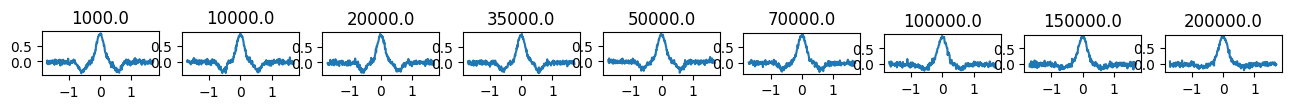

-1.6940296372707655 -4.063694059679759
-1.7161543291859913 -4.116767498969167
-1.6932982360383795 -4.0619395503265
-1.710310426127417 -4.1027489519367
-1.7065310389653745 -4.093682833598673
-1.7079214306301806 -4.097018150894541
-1.7038941733540027 -4.0873574335670835
-1.706463630515605 -4.093521131990346
-1.6993429383930279 -4.076439781320505
-1.7108361524762026 -4.104010081608563
-1.7053037783344065 -4.09073884039689
-1.6926295758832866 -4.0603355463348265
-1.6906343694101937 -4.055549379366931
-1.6921066046652409 -4.059081025761278
-1.6823003473725229 -4.035557452955132
-1.7112835212972957 -4.105083244663544
-1.7004909804510884 -4.0791937424018
-1.7055559466086012 -4.091343749954161
-1.699229382623912 -4.0761673800034055
-1.6895775970983185 -4.053014359157296
-1.7156743263323926 -4.115616052322731
-1.6786205828419805 -4.026730312665026
-1.6995162078995525 -4.0768554259166185
-1.709815321898306 -4.101561279613563
-1.7140873249537223 -4.111809101173048
-1.7152017421339953 -4.114482401

In [38]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
file_end = 'sq_vcat_7db_oddcat_1d'
dd, decay_times, x = load_data_no_average(path, file_end, thresh=0.00016482562703811767, vac_norm=vac_norm)


# initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
scaling = 3
reps = 100

amp1 = -0.4
sigma1 = 0.8
cen1 = -3.5
amp2 = 0.
sigma2 = 1
cen2 = 0
amp3 = -0.4
sigma3 = 0.9
cen3 = 3.5
initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
bounds =([-1, -5, 0 ,0, -0.5, 0 ,-1, 0, 0], 
            [0, 0, 1.1 ,1, 0.5, 1.1 ,0, 5, 1.1])

T_values_7 = extract_decay_constant_bootstrap(dd, decay_times, scaling*x, reps, plot=False, initial_guess=initial_guess, bounds=bounds, dB = 7.6)


In [39]:
print(f"{np.mean(T_values_7)}+-{np.std(T_values_7)}")

242.9107527965352+-29.467056676695563


In [40]:
print(f"{np.mean(T_values_0)}+-{np.std(T_values_0)}")
print(f"{np.mean(T_values_3)}+-{np.std(T_values_3)}")
print(f"{np.mean(T_values_6)}+-{np.std(T_values_6)}")
print(f"{np.mean(T_values_7)}+-{np.std(T_values_7)}")

273.2201785569041+-13.024312605221818
258.08568830077945+-16.57483833871806
264.6689402877539+-28.052489434204777
242.9107527965352+-29.467056676695563
